#A Client-Based Project on Data Mining and Machine Learning: Predictive Quality for Batch Process Manufacturing
##University of Wisconsin, Green Bay
###M.S. in Data Science
####Hector Guido Aldana
####July 2022


This notebook contains Python code to create a model with algorithm One-Class SVM for product 100012. We need to create a model for each product to manufacture because the number of start-up and operational steps regarding quality checks varies. As we explained in the study, we generated a generic data set containing all products. Therefore, we entered NULL in some columns precisely when the step did not apply to the product. We also wrote the code for product 100008 separately. Please check our additional notebook for this case.



Let's start by importing any library we need.

In [94]:
# load a library to explore and manipulate data
import pandas as pd

# load a library for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set warnings 
import warnings
warnings.filterwarnings("ignore")

# import algorithms for imbalanced data sets
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# import NumPy 
import numpy as np
from numpy import vstack

# import f1_score()
from sklearn.metrics import f1_score

# import pi
from math import pi

Let's load the data set for product 100012.

In [95]:
# save filepath to variable for easier access
product_file_path = 'C:\\Users\\taxat\\Capstone2\\Dataset 100012.csv'
# read the data and store data in DataFrame titled product_data
product_data = pd.read_csv(product_file_path) 

# save filepath to variable for easier access
product_good_runs_file_path = 'C:\\Users\\taxat\\Capstone2\\Dataset 100012 - Good Runs.csv'
# read the data and store data in DataFrame titled product_good_runs_data
product_good_runs_data = pd.read_csv(product_good_runs_file_path) 

# save filepath to variable for easier access
product_bad_runs_file_path = 'C:\\Users\\taxat\\Capstone2\\Dataset 100012 - Bad Runs.csv'
# read the data and store data in DataFrame titled product_data
product_bad_runs_data = pd.read_csv(product_bad_runs_file_path) 


We can print summaries describing the data sets.

In [96]:
# print summaries

# print a summary of the data in product_data
#product_data.describe()

# print a summary of the data in product_good_runs_data
#product_good_runs_data.describe()

# print a summary of the data in product_bad_runs_data
#product_bad_runs_data.describe()

Let's complete some Advanced Exploratory Data Analysis (EDA) to understand better our data set. We can look at plots displaying global views of the data set for the numerical features using the pandas' .plot() function. Additionally, we can see the value distribution of each feature using histogram plots and then use seaborn's pairplot to visualize the relationships between the features.

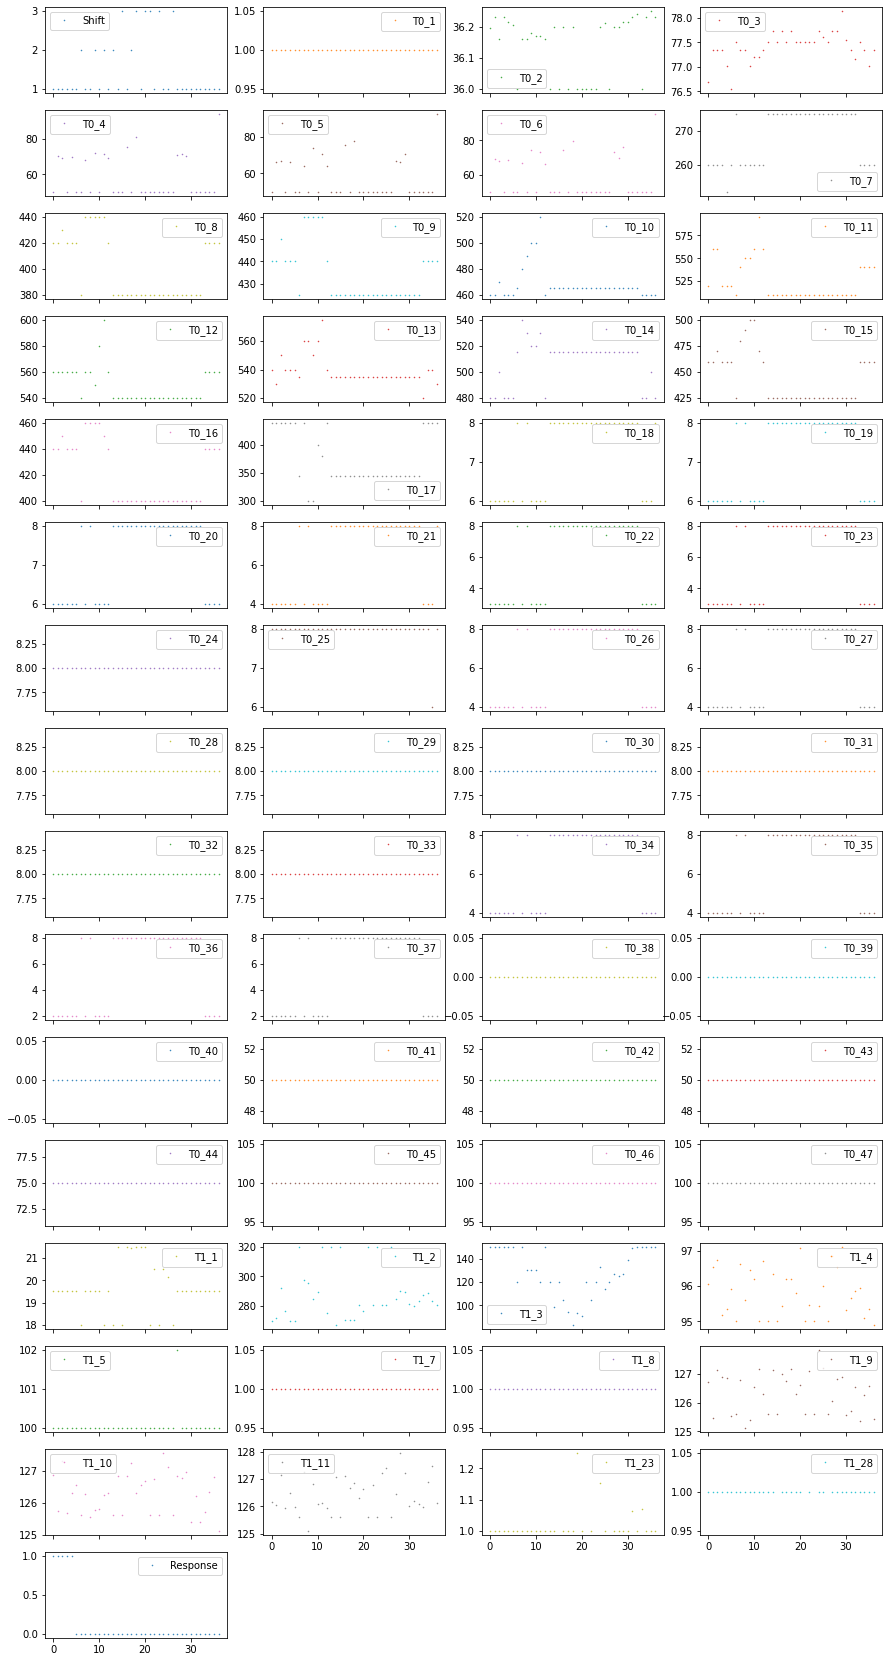

In [97]:
# plot a global view of the data sets
product_data.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),figsize=(15, 30), markersize=1);
#product_good_runs_data.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),figsize=(15, 30), markersize=1);
#product_bad_runs_data.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),figsize=(15, 30), markersize=1);

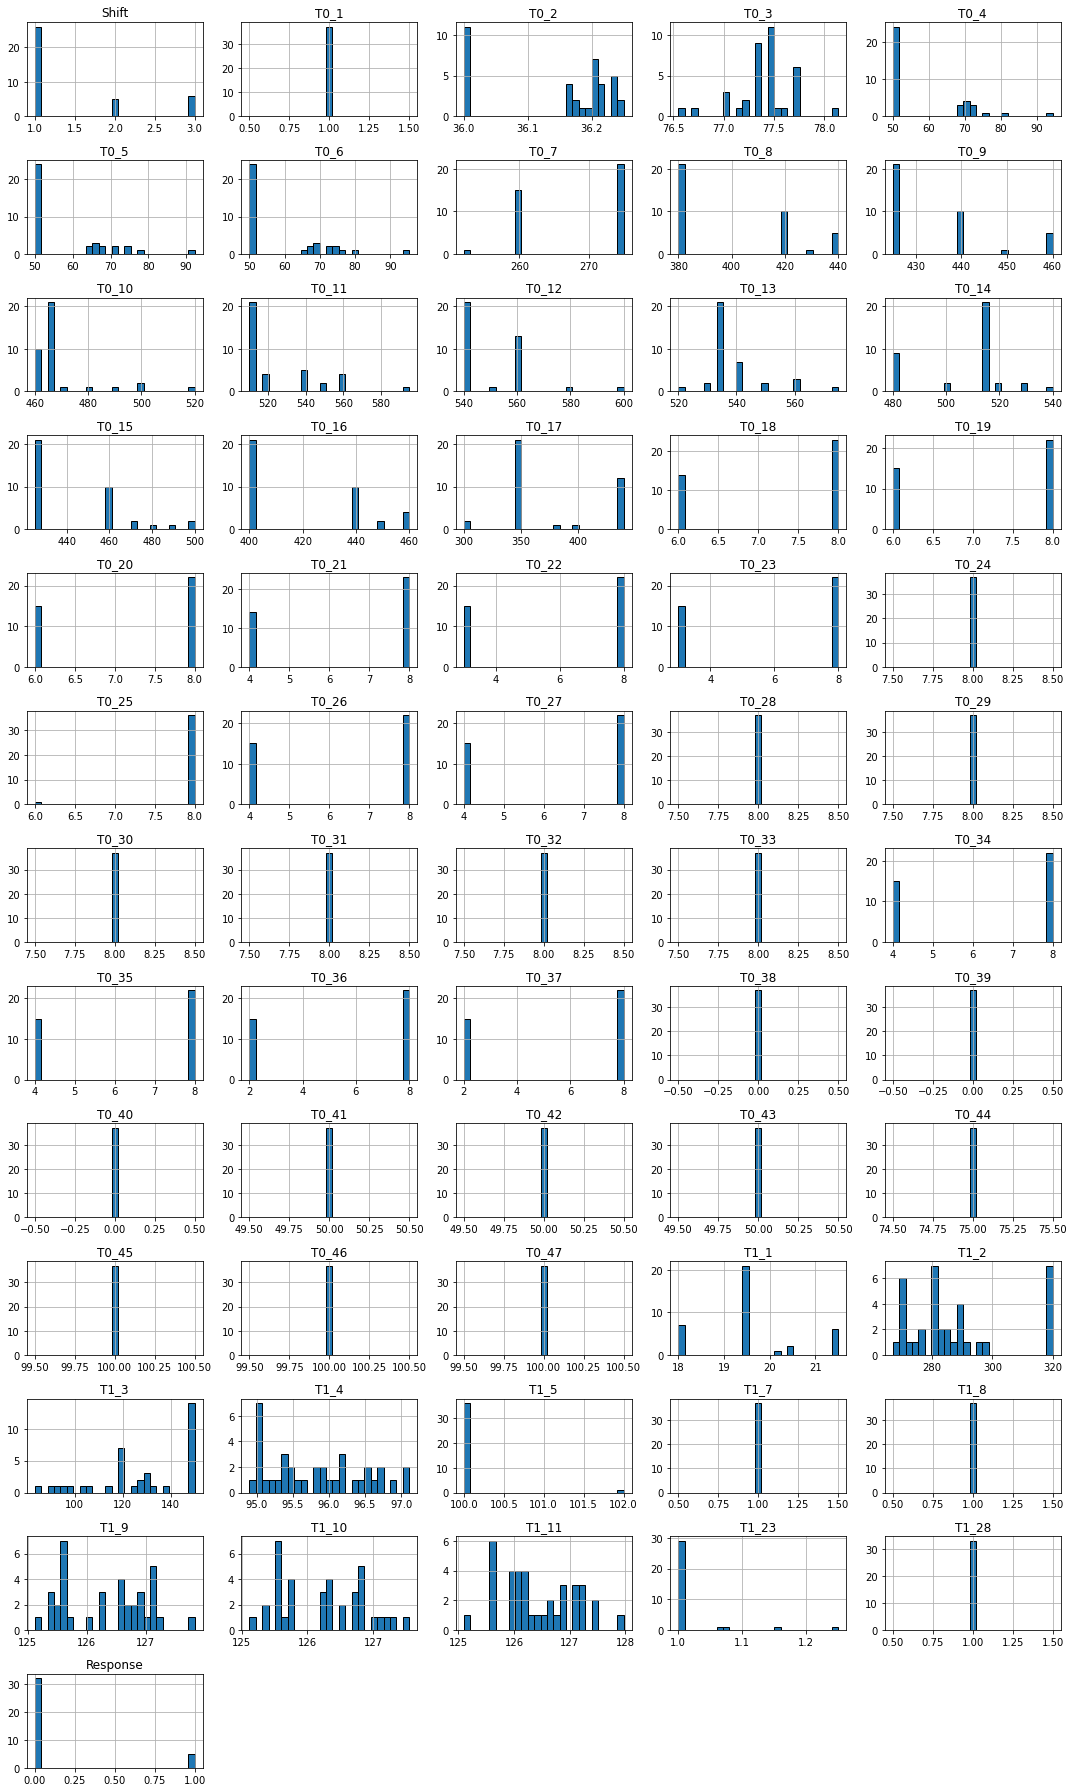

In [98]:
# display the value distribution of each feature
product_data.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
#product_good_runs_data.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
#product_bad_runs_data.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black") 
plt.tight_layout()

In [99]:
# investigate feature patterns

# create mask to identify numerical features with 10 or more unique values
cols_continuous = product_data.select_dtypes(include="number").nunique() >= 10

# Create a new dataframe which only contains the continuous features
df_continuous = product_data[cols_continuous[cols_continuous].index]
df_continuous.shape

(37, 11)

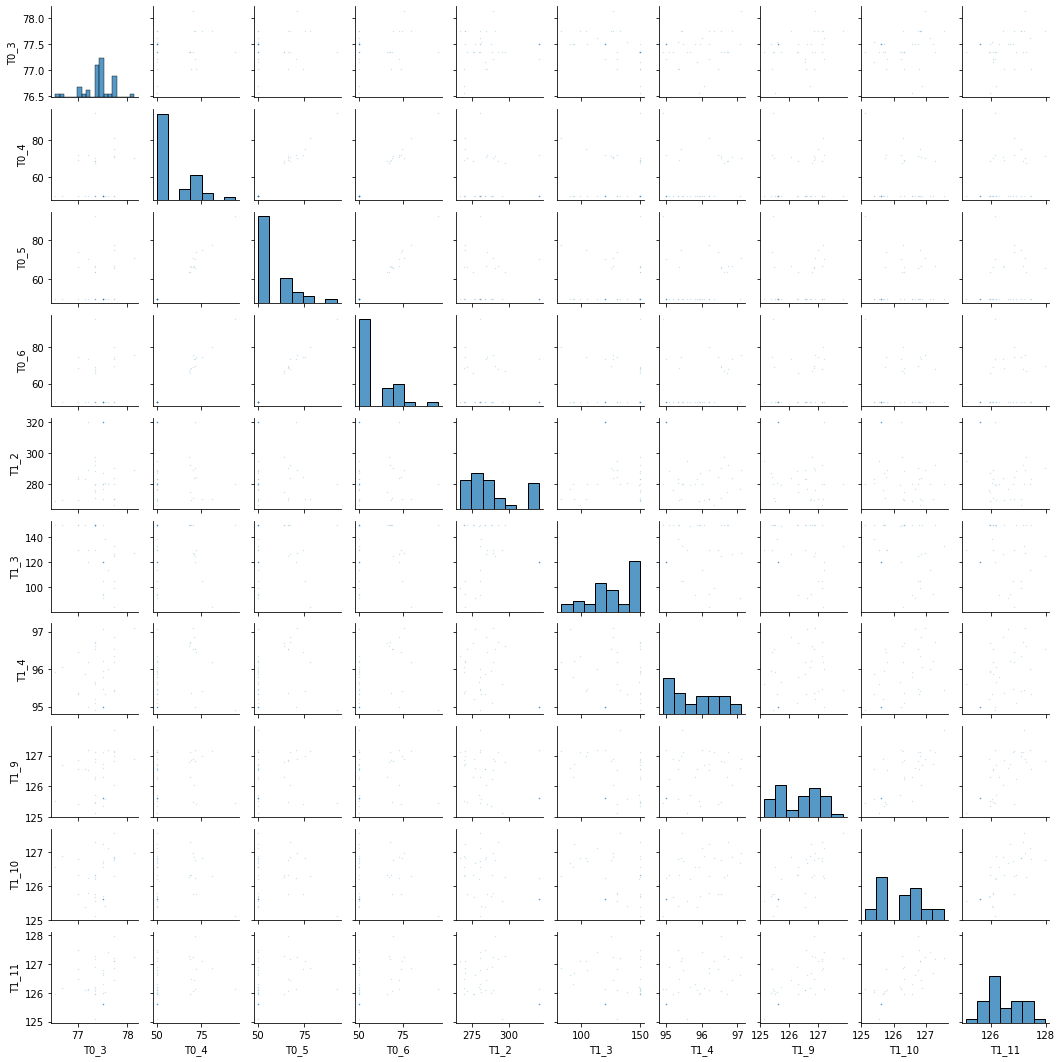

In [100]:
sns.pairplot(df_continuous.iloc[:, 1:11], height=1.5, plot_kws={"s": 2, "alpha": 0.2});

Let's analyze the correlations' strength with a heat map and organize the coefficients from lowest to highest.

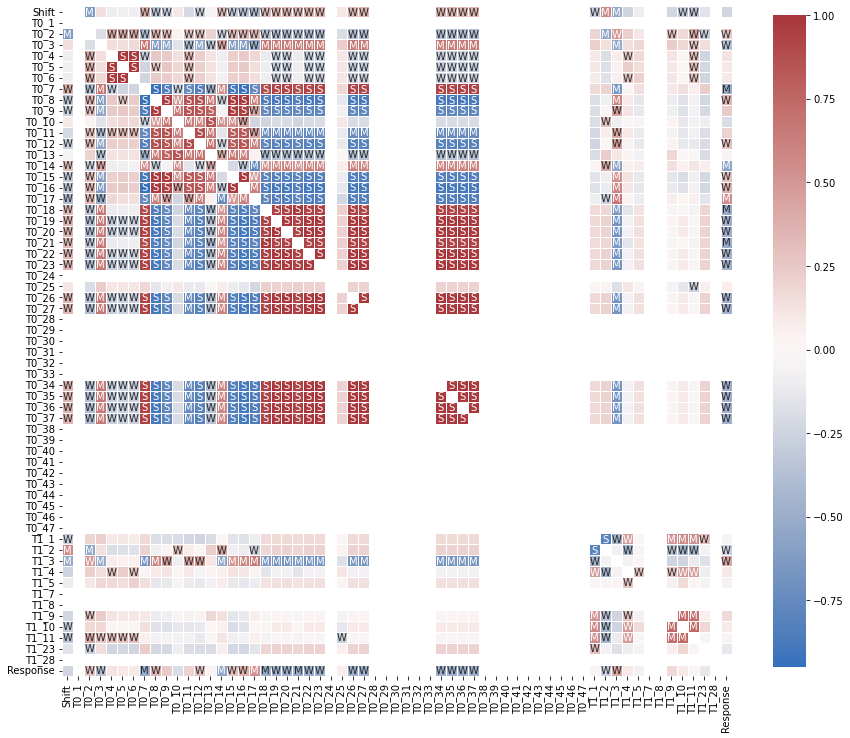

In [101]:
# visualize feature relationship via a heatmap

# Computes feature correlation
df_corr = product_data.corr(method="pearson")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

In [102]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(df_corr_stacked)

T0_16  T0_7    -0.950621
T0_8   T0_7    -0.946937
T0_15  T0_7    -0.895676
T0_35  T0_16   -0.886531
T0_34  T0_16   -0.886531
                  ...   
T0_35  T0_27    1.000000
       T0_26    1.000000
       T0_19    1.000000
T0_36  T0_34    1.000000
T0_23  T0_22    1.000000
Length: 780, dtype: float64

In [103]:
# extract 70% of good product runs with reproducibility
df_70_good = product_good_runs_data.sample(frac=0.70, random_state=1)
dfTraining = df_70_good

# store the remaining 30% of good product runs
df_30_good = product_good_runs_data[~product_good_runs_data.isin(df_70_good)]

# extract 2/3 of good product runs with reproducibility
df_23_good = df_30_good.sample(frac=0.6666, random_state=1)

# extract 50% of bad product runs with reproducibility
df_50_a_bad = product_bad_runs_data.sample(frac=0.50, random_state=1)

# concat of 2/3 of good runs and 50% of the bad runs
dfValidation = pd.concat([df_23_good, df_50_a_bad])

# store the remaining 1/3 of good product runs (from the 30%)
df_13_good = df_30_good[~df_30_good.isin(df_23_good)]

# store the remaining 50% bad product runs 
df_50_b_bad = product_bad_runs_data[~product_bad_runs_data.isin(df_50_a_bad)]

# concat of 1/3 of good runs and 50% of the bad runs
dfTest = pd.concat([df_13_good, df_50_b_bad])

# print summaries of data frames
#df_70_good.describe()
#dfTraining.describe()
#df_30_good.describe()
#df_23_good.describe()
#df_50_a_bad.describe()
#dfValidation .describe()
#df_13_good.describe()
#df_50_b_bad.describe()
#dfTest.describe()

In [104]:
# use complete case only
dfTraining=dfTraining.dropna()
dfValidation=dfValidation.dropna()
dfTest=dfTest.dropna()

# print summaries of complete cases
#dfTraining.describe()
#dfValidation.describe()
#dfTest.describe()

Let's remove higly correlated features.

In [105]:
# exclude highly correlated features
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_8'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_15'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_23'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_35'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_36'])]]


dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_8'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_15'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_23'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_35'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_36'])]]


dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_8'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_15'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_23'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_35'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_36'])]]


In [106]:
# exclude features with single values

dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_1'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_24'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_28'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_29'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_30'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_31'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_32'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_33'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_38'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_39'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_40'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_41'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_42'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_43'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_44'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_45'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_46'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T0_47'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T1_7'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T1_8'])]]
dfTraining=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['T1_28'])]]


dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_1'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_24'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_28'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_29'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_30'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_31'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_32'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_33'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_38'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_39'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_40'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_41'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_42'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_43'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_44'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_45'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_46'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T0_47'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T1_7'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T1_8'])]]
dfValidation=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['T1_28'])]]

dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_1'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_24'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_28'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_29'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_30'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_31'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_32'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_33'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_38'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_39'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_40'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_41'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_42'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_43'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_44'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_45'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_46'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T0_47'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T1_7'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T1_8'])]]
dfTest=dfTest[dfTest.columns[~dfTest.columns.isin(['T1_28'])]]   

In [107]:
# remove response columns
trainX=dfTraining[dfTraining.columns[~dfTraining.columns.isin(['Response'])]]
#trainX

valX=dfValidation[dfValidation.columns[~dfValidation.columns.isin(['Response'])]]
#valX

testX=dfTest[dfTest.columns[~dfTest.columns.isin(['Response'])]]
#testX

In [108]:
print('trainX.shape: ', trainX.shape)
print('valX.shape: ',valX.shape)
print('testX.shape: ',testX.shape)

trainX.shape:  (20, 34)
valX.shape:  (2, 34)
testX.shape:  (11, 34)


Let's train the One-Class SVM algorithm with good runs only, and predict on the validation and test sets. First, we will use nu=0.1. Then we will iterate through nu values from (0, 1] and plot the F1 Score.

### ONE-CLASS SVM. TRAINING WITH 70% GOOD RUNS ONLY & DETECTING BAD RUNS AS OUTLIERS

In [109]:
# define the outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)

# fit on a portion of the majority class
model.fit(trainX) 

OneClassSVM(nu=0.01)

In [110]:
# work with validation data set
# anticipate runs ending in bad product
predictions_val = model.predict(valX)  

# update response variable from 1 to -1 and from 0 to 1
dfValidation.loc[dfValidation["Response"] == 1, "Response"] = -1
dfValidation.loc[dfValidation["Response"] == 0, "Response"] = 1
#dfValidation.describe()

# convert dataframe column to NumPy Array
response_val = dfValidation["Response"].to_numpy() 
#response_val

# determine the harmonic mean
score_label_val = f1_score(response_val, predictions_val, pos_label=-1)
print('F1 Score val set - One-Class SVM: %.3f' % score_label_val)

F1 Score val set - One-Class SVM: 1.000


In [111]:
# work with test data set
# anticipate runs ending in bad product
predictions_test = model.predict(testX)  

# update response variable from 1 to -1 and from 0 to 1
dfTest.loc[dfTest["Response"] == 1, "Response"] = -1
dfTest.loc[dfTest["Response"] == 0, "Response"] = 1
#dfTest.describe()

# convert dataframe column to NumPy Array
response_test = dfTest["Response"].to_numpy() 
#response_test

In [112]:
# determine the harmonic mean
score_label_test = f1_score(response_test, predictions_test, pos_label=-1)
print('F1 Score test set - One-Class SVM: %.3f' % score_label_test)

F1 Score test set - One-Class SVM: 0.500


Max F1 score:  1.0 . nu =  0.001
Max F1 score:  1.0 . nu =  0.001


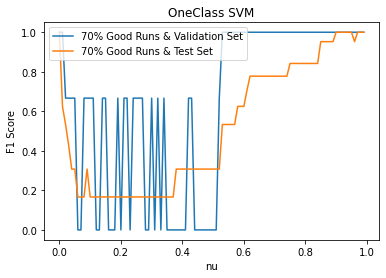

In [113]:
# tune the nu hyper-parameter

def decimal_range(start, stop, increment):
    while start < stop: 
        yield start
        start += increment

# update response variable from 1 to -1 and from 0 to 1
dfValidation.loc[dfValidation["Response"] == 1, "Response"] = -1
dfValidation.loc[dfValidation["Response"] == 0, "Response"] = 1
#dfValidation.describe()   

# convert dataframe column to NumPy Array
response_val = dfValidation["Response"].to_numpy() 
#response_val

# update response variable from 1 to -1 and from 0 to 1
dfTest.loc[dfTest["Response"] == 1, "Response"] = -1
dfTest.loc[dfTest["Response"] == 0, "Response"] = 1
#dfTest.describe()

# convert dataframe column to NumPy Array
response_test = dfTest["Response"].to_numpy() 
#response_test

        
nu_x = []
score_val_y = []
score_test_y = []
for nu_i in decimal_range(0.001, 1.0, 0.01):
    
    # define the outlier detection model
    model = OneClassSVM(gamma='scale', nu=nu_i)

    # fit on a portion of the majority class
    model.fit(trainX) 
    
    # work with validation data set
    # anticipate runs ending in bad product
    predictions_val = model.predict(valX)  

    # convert dataframe column to NumPy Array
    response_val = dfValidation["Response"].to_numpy() 
    #response_val

    # determine the harmonic mean
    score_label_val = f1_score(response_val, predictions_val, pos_label=-1)
    #print('F1 Score val set - One-Class SVM: %.3f' % score_label_val)
    
    
    # work with test data set
    # anticipate runs ending in bad product
    predictions_test = model.predict(testX)  
    
    # determine the harmonic mean
    score_label_test = f1_score(response_test, predictions_test, pos_label=-1)
    #print('F1 Score test set - One-Class SVM: %.3f' % score_label_test)
    
    nu_x.append(nu_i)
    score_val_y.append(score_label_val)
    score_test_y.append(score_label_test)
    #print(nu_i, score_label_val)
    
plt.title("OneClass SVM")
plt.xlabel("nu")
plt.ylabel("F1 Score")    
plt.plot(nu_x, score_val_y, label="70% Good Runs & Validation Set")

max_score = np.max(score_val_y)
idx_score = nu_x[np.argmax(score_val_y)]
print('Max F1 score: ', max_score, '. nu = ', idx_score)


#plt.title("OneClass SVM")
plt.xlabel("nu")
plt.ylabel("F1 Score")    
plt.plot(nu_x, score_test_y, label="70% Good Runs & Test Set")
plt.legend(loc="upper left")

max_score = np.max(score_test_y)
idx_score = nu_x[np.argmax(score_test_y)]
print('Max F1 score: ', max_score, '. nu = ', idx_score)

Let's train the One-Class SVM algorithm with bad runs only, and predict on the good ones.

### ONE-CLASS SVM - # TRAINING WITH BAD RUNS ONLY & DETECTING GOOD RUNS AS OUTLIERS

In [114]:
# define the outlier detection model
model = OneClassSVM(gamma='scale', nu=0.3)

# remove the response column
dfBadOnly = product_bad_runs_data
badOnlyX=dfBadOnly[dfBadOnly.columns[~dfBadOnly.columns.isin(['Response'])]].dropna()
#badOnlyX

dfGoodOnly = product_good_runs_data
goodOnlyX=dfGoodOnly[dfGoodOnly.columns[~dfGoodOnly.columns.isin(['Response'])]].dropna()
#goodOnlyX

response_var = np.zeros(goodOnlyX.shape[0])
response_var[response_var == 0] = 1
#response_var


# fit on a portion of the majority class
model.fit(badOnlyX) 


# work with validation data set
# anticipate runs ending in bad product
predictions_bad_good_only = model.predict(goodOnlyX)  
#predictions_bad_good_only

# determine the harmonic mean
score_label_bad_good = f1_score(response_var, predictions_bad_good_only)
score_label_bad_good
#print('F1 Score val set - One-Class SVM: %.3f' % score_label_bad_good)

0.19354838709677416

Max F1 score:  0.30303030303030304 . nu =  0.3210000000000001


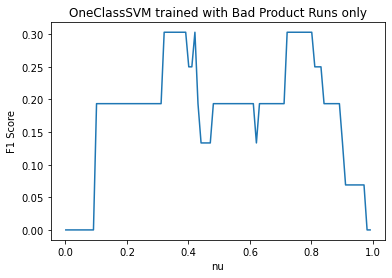

In [115]:
# tune the nu hyper-parameter

def decimal_range(start, stop, increment):
    while start < stop: 
        yield start
        start += increment

nu_x = []
score_y = []
for nu_i in decimal_range(0.001, 1.0, 0.01):
    
    # define the outlier detection model
    model = OneClassSVM(gamma='scale', nu=nu_i)

    # remove the response column
    dfBadOnly = product_bad_runs_data
    badOnlyX=dfBadOnly[dfBadOnly.columns[~dfBadOnly.columns.isin(['Response'])]].dropna()
    #badOnlyX

    dfGoodOnly = product_good_runs_data
    goodOnlyX=dfGoodOnly[dfGoodOnly.columns[~dfGoodOnly.columns.isin(['Response'])]].dropna()
    #goodOnlyX

    response_var = np.zeros(goodOnlyX.shape[0])
    response_var[response_var == 0] = 1
    #response_var


    # fit on a portion of the majority class
    model.fit(badOnlyX) 


    # work with validation data set
    # anticipate runs ending in bad product
    predictions_bad_good_only = model.predict(goodOnlyX)  
    #predictions_bad_good_only

    # determine the harmonic mean
    score_label_bad_good = f1_score(response_var, predictions_bad_good_only)
    #score_label_bad_good
    #print('F1 Score val set - One-Class SVM: %.3f' % score_label_bad_good)
    
    
    nu_x.append(nu_i)
    score_y.append(score_label_bad_good)
    #print(nu_i, score_label_bad_good)
    
plt.title("OneClassSVM trained with Bad Product Runs only")
plt.xlabel("nu")
plt.ylabel("F1 Score")    
plt.plot(nu_x, score_y)

max_score = np.max(score_y)
idx_score = nu_x[np.argmax(score_y)]
print('Max F1 score: ', max_score, '. nu = ', idx_score)

### GRADIENT BOOSTING ALGORITHM - TRAINING WITH GOOD AND BAD PRODUCT RUNS & SAMPLE WEIGHTS

In [116]:
# extract 70% of good product runs with reproducibility
df_70_good_gb = product_good_runs_data.sample(frac=0.70, random_state=1)

# store the remaining 30% of good product runs
df_30_good_gb = product_good_runs_data[~product_good_runs_data.isin(df_70_good_gb)]


# extract 30% of bad product runs with reproducibility
df_bad_a_gb = product_bad_runs_data.sample(frac=0.30, random_state=1)

# store the remaining 30% of bad product runs
df_bad_b_gb = product_bad_runs_data[~product_bad_runs_data.isin(df_bad_a_gb)]

# compose the training set
dfTraining_gb = pd.concat([df_70_good_gb, df_bad_a_gb])

# compose the test set
dfTest_gb = pd.concat([df_30_good_gb, df_bad_b_gb])

# exclude highly correlated features
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_8'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_15'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_23'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_35'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_36'])]]


dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_8'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_15'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_23'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_35'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_36'])]]

# exclude features with single values
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_1'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_24'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_28'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_29'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_30'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_31'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_32'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_33'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_38'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_39'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_40'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_41'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_42'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_43'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_44'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_45'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_46'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_47'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T1_7'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T1_8'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T1_28'])]]

dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_1'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_24'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_28'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_29'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_30'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_31'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_32'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_33'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_38'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_39'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_40'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_41'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_42'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_43'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_44'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_45'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_46'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_47'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T1_7'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T1_8'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T1_28'])]]



# use complete case only
dfTraining_gb=dfTraining_gb.dropna()
dfTest_gb=dfTest_gb.dropna()

# print sets of complete cases
# dfTraining_gb
# dfTest_gb

In [117]:
# print set sizes
print('dfTraining_gb: ', dfTraining_gb.shape)
print('dfTest_gb', dfTest_gb.shape)

dfTraining_gb:  (22, 35)
dfTest_gb (11, 35)


In [118]:
# separate from response
X_train=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['Response'])]]
Y_train=dfTraining_gb['Response']

X_test=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['Response'])]]
Y_test=dfTest_gb['Response']


In [119]:
# set higher weights to bad product runs
sample_weights = np.zeros(len(Y_train))
sample_weights[Y_train == 0] = 0.5
sample_weights[Y_train == 1] = 9.1

# define Gradient Boosting Classifier with hyperparameters
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100 )

# fit train data to GBC
gbc.fit(X_train,Y_train, sample_weight = sample_weights)

# make predictions
predictions_gb=gbc.predict(X_test)

# confusion matrix will give number of correct and incorrect classifications
# the number of misclassifications by the Gradient Boosting Classifier is 1, compared to 66 correct classifications.
print('Confusion matrix: ')
print(confusion_matrix(Y_test, predictions_gb))

# model accuracy
print("GBC accuracy is %2.2f" % accuracy_score(Y_test, predictions_gb))


# print classification report
# accuracy of 99%
print(classification_report(Y_test, predictions_gb))

Confusion matrix: 
[[7 1]
 [3 0]]
GBC accuracy is 0.64
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78         8
         1.0       0.00      0.00      0.00         3

    accuracy                           0.64        11
   macro avg       0.35      0.44      0.39        11
weighted avg       0.51      0.64      0.57        11



### GRADIENT BOOSTING ALGORITHM - TRAINING WITH GOOD AND RESAMPLED BAD PRODUCT RUNS

In [120]:
# balancing with Bootsrap resampling and replacement
bad_data_resample=product_bad_runs_data.dropna()
balanced_sample_size=product_good_runs_data.dropna().shape[0]

# scikit-learn bootstrap
from sklearn.utils import resample

# prepare bootstrap sample
boot = resample(bad_data_resample, replace=True, n_samples=balanced_sample_size, random_state=1)
boot.shape
#boot
#print('Bootstrap Sample: %s' % boot)
# out of bag observations
#oob = [x for x in bad_data_resample if x not in boot]
#print('OOB Sample: %s' % oob)

(28, 61)

In [121]:
# extract 50% of good product runs with reproducibility
df_good_a_gb = product_good_runs_data.sample(frac=0.50, random_state=1)

# store the remaining 30% of good product runs
df_good_b_gb = product_good_runs_data[~product_good_runs_data.isin(df_good_a_gb)]


# extract 50% of bad product runs with reproducibility
df_bad_a_gb = boot.iloc[:119, :]

# store the remaining 50% of bad product runs
df_bad_b_gb =  boot.iloc[120:, :]

# compose the training set
dfTraining_gb = pd.concat([df_good_a_gb, df_bad_a_gb])

# compose the test set
dfTest_gb = pd.concat([df_good_b_gb, df_bad_b_gb])

# exclude highly correlated features
# exclude highly correlated features
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_8'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_15'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_23'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_35'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_36'])]]


dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_8'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_15'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_23'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_35'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_36'])]]

# exclude features with single values
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_1'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_24'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_28'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_29'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_30'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_31'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_32'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_33'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_38'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_39'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_40'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_41'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_42'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_43'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_44'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_45'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_46'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T0_47'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T1_7'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T1_8'])]]
dfTraining_gb=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['T1_28'])]]

dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_1'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_24'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_28'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_29'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_30'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_31'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_32'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_33'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_38'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_39'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_40'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_41'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_42'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_43'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_44'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_45'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_46'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T0_47'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T1_7'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T1_8'])]]
dfTest_gb=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['T1_28'])]]

# use complete case only
dfTraining_gb=dfTraining_gb.dropna()
dfTest_gb=dfTest_gb.dropna()

# print sets of complete cases
# dfTraining_gb
# dfTest_gb

In [122]:
# print set sizes
print('dfTraining_gb: ', dfTraining_gb.shape)
print('dfTest_gb', dfTest_gb.shape)

dfTraining_gb:  (44, 35)
dfTest_gb (12, 35)


In [123]:
# separate from response
X_train=dfTraining_gb[dfTraining_gb.columns[~dfTraining_gb.columns.isin(['Response'])]]
Y_train=dfTraining_gb['Response']

X_test=dfTest_gb[dfTest_gb.columns[~dfTest_gb.columns.isin(['Response'])]]
Y_test=dfTest_gb['Response']

In [124]:
# set higher weights for bad product runs
sample_weights = np.zeros(len(Y_train))
sample_weights[Y_train == 0] = 0.5
sample_weights[Y_train == 1] = 9.1

# define Gradient Boosting Classifier with hyperparameters
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100 )

# fit train data to GBC. Removed sample_weights because we have a more balanced data set
gbc.fit(X_train,Y_train)

# make predictions
predictions_gb=gbc.predict(X_test)

# confusion matrix will give number of correct and incorrect classifications
# the number of misclassifications by the Gradient Boosting Classifier is 1, compared to 66 correct classifications.
print('Confusion matrix: ')
print(confusion_matrix(Y_test, predictions_gb))

# model accuracy
print("GBC accuracy is %2.2f" % accuracy_score(Y_test, predictions_gb))


# print classification report
# accuracy of 97%
print(classification_report(Y_test, predictions_gb))

Confusion matrix: 
[[11  1]
 [ 0  0]]
GBC accuracy is 0.92
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        12
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92        12
   macro avg       0.50      0.46      0.48        12
weighted avg       1.00      0.92      0.96        12

